In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# Root path of the data files
# Change this to "Runs30" to use the smaller dataset
DATA_FOLDER = "Data/Runs300"

# Lookup table for full experiment names
EXPERIMENT_NAMES = \
{
	"EX1": "EX1. Baseline",
	"EX2": "EX2. WithoutAnchoring",
	"EX3": "EX3. WithAnchoring",
}

# Aliases for the reporters we are interested in
REPORTERS = \
{
	"num_believers": "count turtles with [state = \"B\"]"

}

# The value for S_{max-verify} that we use as our reference
# Based on real-world measured values
REFERENCE_S_MAX_VERIFY = 0.2

# Helper function to swap keys and values in a dictionary
invert_dict = lambda x: { value: key for key, value in x.items() }

def experiment_file(experiment_label):
	return f'{DATA_FOLDER}/InformationDiffusionProcesModel {EXPERIMENT_NAMES[experiment_label]}-table.csv'

def load_experiment(experiment_label):
	file_name = experiment_file(experiment_label)

	# Read CSV for file, skip 6 rows as they are meta data
	df = pd.read_csv(file_name, skiprows=6)
	df = df.rename(columns=invert_dict(REPORTERS)) # Remap reporter names according to our aliases
	df = df.sort_values(by='[step]')

	return df

In [3]:
def split_df(df, key):
	"""Split the data frame by the given key, returns a list of data frames"""
	df_grouped = df.groupby(key)
	return [ df_grouped.get_group(x) for x in df_grouped.groups ]

def calculate_stats(df):
	"""Calculates our derived stats for the given run data frame"""
	num_believers = df['num_believers']
	initial_agents = df['number-of-agents'].iloc[0]
	initial_believers = num_believers.iloc[0]
	max_believers = num_believers.max()

	hoax_persistence = num_believers.iloc[-10:].mean() / initial_agents
	hoax_spread = (max_believers - initial_believers) / num_believers.argmax()
	hoax_reach = max_believers / initial_agents

	return { 'hoax_persistence': hoax_persistence, 'hoax_spread': hoax_spread, 'hoax_reach': hoax_reach }



In [4]:
def process_experiment(experiment_label, group_key = None):
	df = load_experiment(experiment_label)

	if group_key is not None:
		variations = split_df(df, group_key)
	else:
		variations = [ df ]

	result = { }

	for df in variations:
		runs = split_df(df, '[run number]')
		
		stats = pd.DataFrame([ calculate_stats(df) for df in runs ])

		variation_key = df[group_key].iloc[0] if group_key is not None else None
		result[variation_key] = stats

	#return { key: stats[key].mean() for key in stats.columns }
	return result

In [5]:
# Calculate our derived variables for each experiment run
ex1 = process_experiment('EX1')
ex2 = process_experiment('EX2', 'max-susceptibility-to-verify')
ex3 = process_experiment('EX3', 'max-susceptibility-to-verify')

ex1, ex2, ex3

({None:      hoax_persistence  hoax_spread  hoax_reach
  0              0.0000       140.50       0.667
  1              0.0000       114.60       0.656
  2              0.0000       108.40       0.641
  3              0.0070       138.25       0.641
  4              0.0095       136.75       0.635
  ..                ...          ...         ...
  295            0.0628       139.00       0.647
  296            0.0265       140.25       0.658
  297            0.0489       102.00       0.615
  298            0.0016       109.40       0.657
  299            0.0000        94.80       0.592
  
  [300 rows x 3 columns]},
 {0.1:      hoax_persistence  hoax_spread  hoax_reach
  0              0.4838    26.150000       0.621
  1              0.5645     5.089109       0.628
  2              0.5114     7.855072       0.634
  3              0.5376     7.223684       0.652
  4              0.5721    21.720000       0.647
  ..                ...          ...         ...
  295            0.4657     

Means: [0.017656666666666668, 0.5039676666666666, 0.6349656666666667]
EX1 - EX2: T-stat: -201.89766; P-value: 0.0000000000
EX1 - EX3: T-stat: -274.09686; P-value: 0.0000000000
EX2 - EX3: T-stat: -54.02375; P-value: 0.0000000000


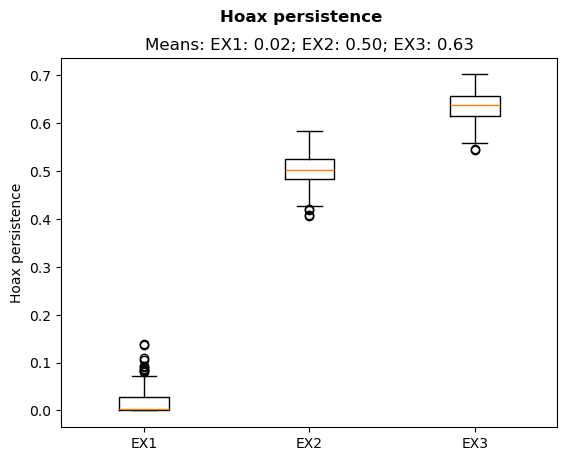

In [6]:
reference_results = [ ex1[None], ex2[REFERENCE_S_MAX_VERIFY], ex3[REFERENCE_S_MAX_VERIFY] ]

persistence_values = [ df['hoax_persistence'] for df in reference_results ]
persistence_means = [ df.mean() for df in persistence_values ]

t_stat12, p_value12 = stats.ttest_rel(persistence_values[0], persistence_values[1])
t_stat13, p_value13 = stats.ttest_rel(persistence_values[0], persistence_values[2])
t_stat23, p_value23 = stats.ttest_rel(persistence_values[1], persistence_values[2])


fig = plt.boxplot(
	x=persistence_values,
	labels=[ 'EX1', 'EX2', 'EX3'],
)

plt.ylabel('Hoax persistence')
plt.suptitle('Hoax persistence', weight='bold')
plt.title(f'Means: EX1: {persistence_means[0]:.2f}; EX2: {persistence_means[1]:.2f}; EX3: {persistence_means[2]:.2f}')

print(f'Means: {persistence_means}')
print(f'EX1 - EX2: T-stat: {t_stat12:.5f}; P-value: {p_value12:.10f}')
print(f'EX1 - EX3: T-stat: {t_stat13:.5f}; P-value: {p_value13:.10f}')
print(f'EX2 - EX3: T-stat: {t_stat23:.5f}; P-value: {p_value23:.10f}')

Means: [131.30416666666667, 26.622077655193607, 29.17529201746351]
EX1 - EX2: T-stat: 79.21183; P-value: 0.0000000000
EX1 - EX3: T-stat: 78.45684; P-value: 0.0000000000
EX2 - EX3: T-stat: -2.99572; P-value: 0.0029671117


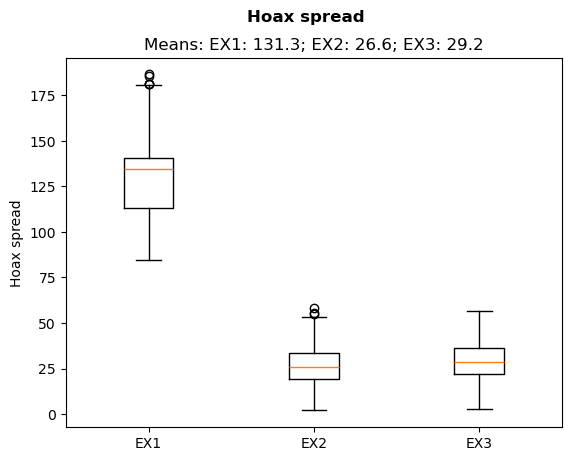

In [7]:
spread_values = [ df['hoax_spread'] for df in reference_results ]
spread_means = [ df.mean() for df in spread_values ]

t_stat12, p_value12 = stats.ttest_rel(spread_values[0], spread_values[1])
t_stat13, p_value13 = stats.ttest_rel(spread_values[0], spread_values[2])
t_stat23, p_value23 = stats.ttest_rel(spread_values[1], spread_values[2])

fig = plt.boxplot(
	x=spread_values,
	labels=[ 'EX1', 'EX2', 'EX3'],
)

plt.ylabel('Hoax spread')
plt.suptitle('Hoax spread', weight='bold')
plt.title(f'Means: EX1: {spread_means[0]:.1f}; EX2: {spread_means[1]:.1f}; EX3: {spread_means[2]:.1f}')

print(f'Means: {spread_means}')
print(f'EX1 - EX2: T-stat: {t_stat12:.5f}; P-value: {p_value12:.10f}')
print(f'EX1 - EX3: T-stat: {t_stat13:.5f}; P-value: {p_value13:.10f}')
print(f'EX2 - EX3: T-stat: {t_stat23:.5f}; P-value: {p_value23:.10f}')

In [28]:
def line_stats(result, column):
	mean = { key: df[column].mean() for key, df in result.items() }
	error = [ (df[column] - mean[key]).abs().mean() for key, df in result.items() ]

	return (mean, error)

def results_to_array(result, column):
	return np.array([ df[column] for key, df in sorted(result.items(), key=lambda pair: pair[0]) ]).T

P-value (EX2 < EX3): [7.65692748e-144 1.32200371e-156 1.75581128e-138 3.98619829e-128
 5.22287619e-116 8.37466613e-085 7.53347487e-048 4.07342625e-010
 1.00000000e+000 1.00000000e+000]


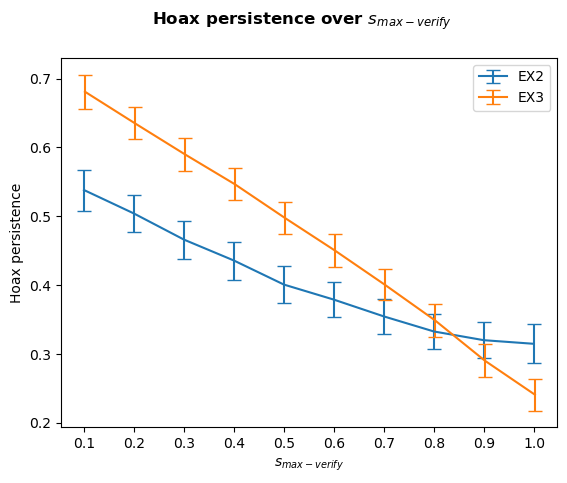

In [32]:
from matplotlib.transforms import Affine2D

column = 'hoax_persistence'
mean_ex2, err_ex2 = line_stats(ex2, column)
mean_ex3, err_ex3 = line_stats(ex3, column)
t_stats, p_values = stats.ttest_rel(results_to_array(ex2, column), results_to_array(ex3, column), alternative='less')

fig, ax = plt.subplots()

t1 = Affine2D().translate(-0.001, 0.0) + ax.transData
t2 = Affine2D().translate(+0.001, 0.0) + ax.transData
ax.errorbar(mean_ex2.keys(), mean_ex2.values(), label="EX2", yerr=err_ex2, capsize=5, transform=t1)
ax.errorbar(mean_ex3.keys(), mean_ex3.values(), label="EX3", yerr=err_ex3, capsize=5, transform=t2)

plt.suptitle('Hoax persistence over $s_{max-verify}$', weight='bold')
plt.xlabel('$s_{max-verify}$')
plt.ylabel('Hoax persistence')
plt.xticks(np.arange(0.1, 1.1, 0.1))

plt.legend()

print(f'P-value (EX2 < EX3): {p_values}')

P-value (EX2 < EX3): [9.18624414e-01 1.48355583e-03 3.64693245e-06 1.01698046e-06
 4.44591247e-11 2.42066260e-13 8.83153295e-23 9.77803939e-19
 4.64955495e-22 3.19104779e-28]


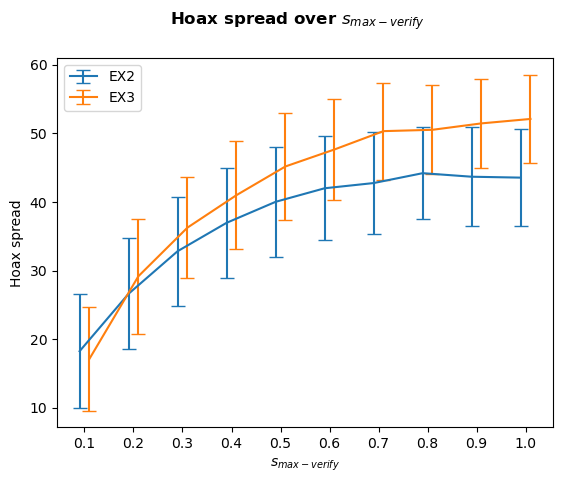

In [33]:
column = 'hoax_spread'
mean_ex2, err_ex2 = line_stats(ex2, column)
mean_ex3, err_ex3 = line_stats(ex3, column)
t_stats, p_values = stats.ttest_rel(results_to_array(ex2, column), results_to_array(ex3, column), alternative='less')

fig, ax = plt.subplots()

t1 = Affine2D().translate(-0.01, 0.0) + ax.transData
t2 = Affine2D().translate(+0.01, 0.0) + ax.transData
ax.errorbar(mean_ex2.keys(), mean_ex2.values(), label="EX2", yerr=err_ex2, capsize=5, transform=t1)
ax.errorbar(mean_ex3.keys(), mean_ex3.values(), label="EX3", yerr=err_ex3, capsize=5, transform=t2)

plt.suptitle('Hoax spread over $s_{max-verify}$', weight='bold')
plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.xlabel('$s_{max-verify}$')
plt.ylabel('Hoax spread')
plt.legend()

print(f'P-value (EX2 < EX3): {p_values}')